In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\felix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:
# Imports

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

c:\Users\felix\Downloads\tweets_covid\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Combine the clean_tweet column into a single array
def create_docs(df):
    docs = []
    for i in df['clean_tweet'].astype(str):
#         word_tokens = word_tokenize(fl)
#         txt = " ".join([w for w in word_tokens])
        docs.append(i)
    return docs

# Flattening lists
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

# Vectorizer: convert the text data into the format that NLP algorithms can process
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X


def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=1,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [3]:
# Read the CSV files
df = pd.read_csv("Covid-19 Twitter Dataset (Apr-Jun 2021).csv")

df= df[['clean_tweet','sentiment']]

# Removing Nans
df = df[df['clean_tweet'].notnull()]

df = df[df["clean_tweet"].str.strip().str.len()>0]

df = df[df['clean_tweet'].str.strip().astype(bool)]

In [4]:
# Tokenize the text and get frequency distribution
tweets = create_docs(df)

tokenized_sents = [word_tokenize(i) for i in tweets]

bag_of_words = flatten_extend(tokenized_sents)

word_counts = Counter(bag_of_words)

# EDA

In [ ]:
len(df['clean_tweet'])

146526

In [ ]:
# Get the top 50 most common words and their frequencies
top_words = word_counts.most_common(30)

# Extracting words and frequencies
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar chart
plt.bar(words, frequencies)

# Adding labels and title
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Top 30 Word Frequencies')

# Rotating x-axis labels for better readability
plt.xticks(rotation=90)

# Displaying the plot
plt.show()

### Min, Max word in a tweet and average word per tweet

c:\Users\felix\Downloads\tweets_covid\.venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\felix\Downloads\tweets_covid\.venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\felix\Downloads\tweets_covid\.venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


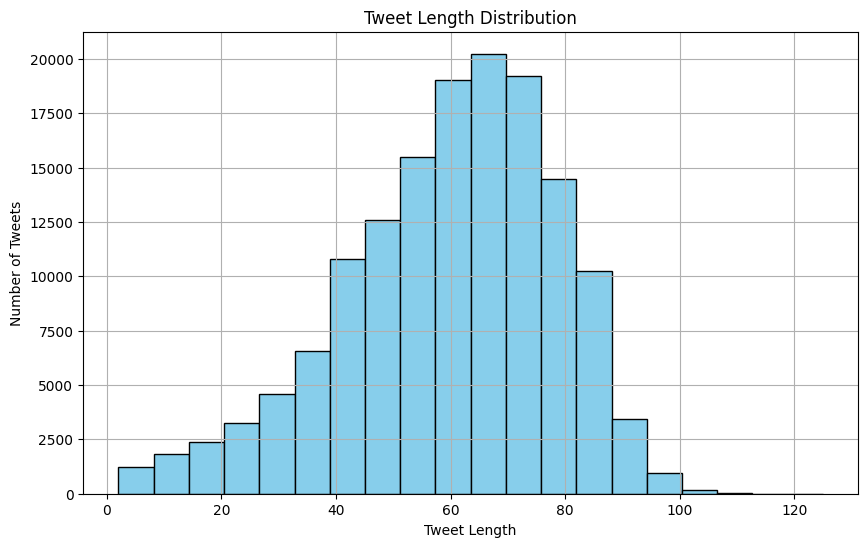

In [6]:
df['tweet_length'] = df['clean_tweet'].apply(len)

# Plot tweet count distribution
plt.figure(figsize=(10, 6))
plt.hist(df['tweet_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

In [7]:
df['tweet_length'].max()

125

In [8]:
df['tweet_length'].min()

2

In [9]:
df['tweet_length'].sum()/len(df['tweet_length'])

59.71589342505767

# LDA

In [10]:
# Tokenize documents
tokenized_docs = [doc.split() for doc in tweets]
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [11]:
lda_model = gensim.models.LdaModel(corpus=corpus, # tokenized document
                                    num_topics=10, # Number of topics to be generated
                                    id2word=dictionary, # dictionary of (token_id, word)
                                    random_state = 1, # random seed
                                    passes=10, # number of passes through the corpus during training
                                    alpha='auto', 
                                    chunksize=5000) # number of documents to be used in each training chunck

In [ ]:
# Print the keyword of topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.032*"pm" + 0.027*"clinic" + 0.025*"open" + 0.024*"free" + 0.020*"join" + 0.017*"st" + 0.017*"centr" + 0.016*"woman" + 0.016*"resid" + 0.015*"offer"'), (1, '0.041*"peopl" + 0.037*"get" + 0.022*"one" + 0.016*"time" + 0.016*"need" + 0.014*"take" + 0.014*"help" + 0.014*"go" + 0.014*"work" + 0.013*"like"'), (2, '0.164*"covid19" + 0.036*"case" + 0.034*"new" + 0.021*"death" + 0.018*"test" + 0.016*"report" + 0.015*"today" + 0.015*"day" + 0.014*"june" + 0.011*"state"'), (3, '0.077*"covid19" + 0.020*"pandem" + 0.019*"health" + 0.016*"say" + 0.013*"variant" + 0.012*"govern" + 0.009*"delta" + 0.008*"use" + 0.008*"restrict" + 0.008*"spread"'), (4, '0.064*"avail" + 0.048*"appoint" + 0.047*"book" + 0.037*"sign" + 0.026*"walgreen" + 0.020*"address" + 0.020*"code" + 0.018*"detect" + 0.017*"zip" + 0.016*"park"'), (5, '0.025*"trump" + 0.024*"presid" + 0.020*"minist" + 0.017*"fauci" + 0.014*"hous" + 0.014*"leader" + 0.014*"offic" + 0.012*"chief" + 0.012*"hold" + 0.010*"account"'), (6, '0.025*"wave

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.680067872229221

Coherence Score:  0.33701444722362206


In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.show(vis, local=False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [10/May/2024 01:42:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/May/2024 01:42:54] code 404, message Not Found
127.0.0.1 - - [10/May/2024 01:42:54] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


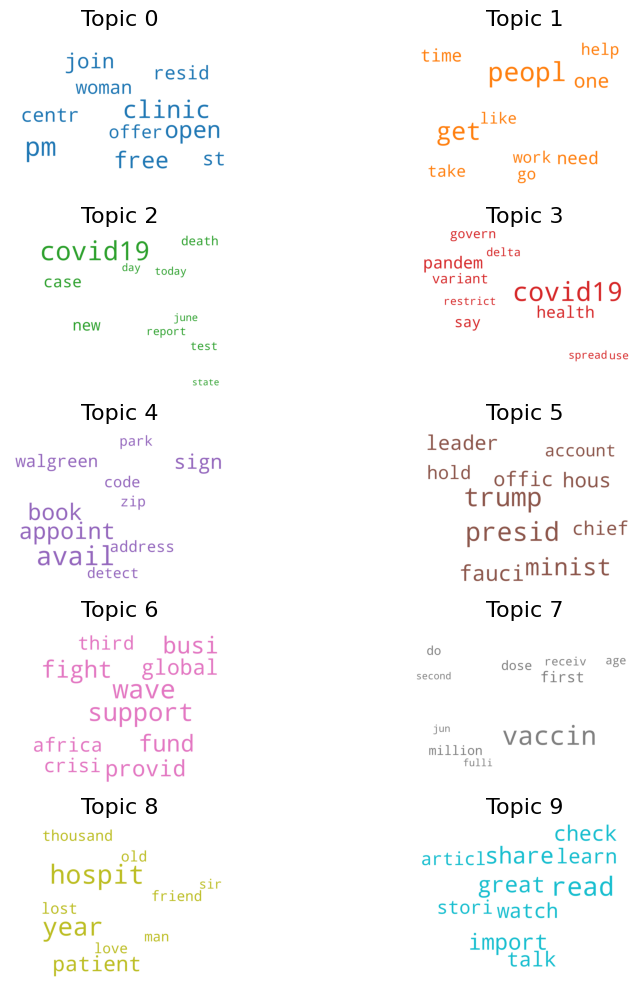

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# BERTopic

In [75]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric='euclidean')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=10, metric='euclidean')

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [107]:
# Bertopic model training
topics, probs = topic_model.fit_transform(tweets)

c:\Users\felix\Downloads\tweets_covid\.venv\Lib\site-packages\hdbscan\hdbscan_.py:1170: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.



## Topic Reduction

In [108]:
# reduce outliers
reduced_outliers_topics = topic_model.reduce_outliers(tweets, topics)

In [109]:
topic_model.update_topics(tweets, topics=reduced_outliers_topics)

2024-05-10 04:39:09,251 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [110]:
# Further reduce topics
topic_model.reduce_topics(tweets, nr_topics=10)

In [118]:
topic_model.visualize_barchart(n_words=8, top_n_topics=9)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.014892738171752549, 0.015379249673932449,
                    0.016270660848728767, 0.017710061455676822,
                    0.021049465783466163, 0.023055530052325406,
                    0.03910534320603813, 0.06073060624276371],
              'xaxis': 'x',
              'y': [pandem  , death  , get  , peopl  , new  , case  , vaccin  ,
                    covid19  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02576779007023072, 0.034383602471066976,
                    0.03524711738208535, 0.03847484058025348, 0.05482610642890828,
                    0.10121480287872416, 0.15766025997193228, 0.34125571480234984],
              'xaxis': 'x2',
              'y': [hand  , mandat  , social  , covid19  , distanc  , face  , wear
                    , mask  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.08836928610878796, 0.09004051806143668, 0.092150055363274,
                    0.09230701973844135, 0.09497049957329445, 0.20618449869208735,
                    0.23128127580886992, 0.25409371540919334],
              'xaxis': 'x3',
              'y': [new  , zip  , code  , jun  , locat  , appoint  , avail  ,
                    walgreen  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.030944265209736938, 0.05886114017238624,
                    0.07656607626687595, 0.07739653316161257, 0.13079880381773407,
                    0.13450395584843383, 0.180875818237846, 0.18490710483755904],
              'xaxis': 'x4',
              'y': [covid19  , restrict  , cosponsor  , folk  , lot  , mean  ,
                    would  , pleas  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.04158063448744963, 0.045423525891985894,
                    0.04709795582102014, 0.05233006083830996, 0.06258452126209232,
                    0.08311278924346989, 0.09026718223060216, 0.2746974523059642],
              'xaxis': 'x5',
              'y': [peac  , bori  , interact  , hugo  , dictat  , normal  , mani
                    , talk  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.049734997149471265, 0.05344868143227685,
                    0.06453373534131553, 0.06961692473409593, 0.07359958568754814,
                    0.07594496899320684, 0.07829406019717762, 0.0881743360353954],
              'xaxis': 'x6',
              'y': [nearli  , violat  , month  , across  , take  , place  , human
                    , right  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.025419230164451436, 0.02568821781023768,
                    0.03246649707945011, 0.03526741550204783, 0.03625275458199902,
                    0.03920793413488057, 0.5379789776715631, 0.7239558949021896],
              'xaxis': 'x7',
              'y': [wrong  , front  , check  , updat  , covid19  , resourc  ,
                    brave  , page  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02153478760462232, 0.026838416707995704,
                    0.027455945524937294, 0.0486338457641843, 0.07391800957159478,
                    0.07944597081670518, 0.13562750405137344, 0.2932910190827571],
              'xaxis': 'x8',
              'y': [wish  ,

In [112]:
topic_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'covid19 | vaccin | case | new | peopl', 131895],
                                   [1, 'mask | wear | face | distanc | covid19', 2542],
                                   [2, 'walgreen | avail | appoint | locat | jun', 3314],
                                   [3, 'pleas | would | mean | lot | folk', 1939],
                                   [4, 'talk | mani | normal | dictat | hugo', 1138],
                                   [5, 'right | human | place | take | across', 2663],
                                   [6, 'page | brave | resourc | covid19 | updat', 211],
                                   [7, 'good | blood | night | morn | anna', 890],
                                   [8, 'impact | call | econom | step | financi', 1903]], dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([131895,   2542,   3314,   1939,   1138,   2663,    211,    890,   1903],
                                       dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 82.434375,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([10.574621 , 10.082575 ,  8.468006 , 10.457511 ,  9.569582 , 11.137652 ,
                           6.6326585, 10.777299 ,  8.108218 ], dtype=float32),
              'xaxis': 'x',
              'y': array([2.8759413, 3.1309202, 0.9493572, 2.0112946, 1.9408909, 2.2460048,
                          1.8046709, 1.4635113, 2.629302 ], dtype=float32),
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': 5.637759709358216,
                                'y': 2.2037559136748315,
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': 9.22302998304367,
                                'xshift': 10,
                                'y': 3.6005581974983216}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': '#CFD8DC', 'width': 2},
                           'type': 'line',
                           'x0': 9.22302998304367,
                           'x1': 9.22302998304367,
                           'y0': 0.8069536298513412,
                           'y1': 3.6005581974983216},
                          {'line': {'color': '#9E9E9E', 'width': 2},
                           'type': 'line',
                           'x0': 5.637759709358216,
                           'x1': 12.808300256729126,
                           'y0': 2.2037559136748315,
                           'y1': 2.2037559136748315}],
               'sliders': [{'active': 0,
                            'pad': {'t': 50},
                            'steps': [{'args': [{'marker.color': [['red',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                           

In [113]:
topic_model.get_topic_freq()

,Topic,Count
0,0,131895
4,2,3314
5,5,2663
3,1,2542
1,3,1939
2,8,1903
7,4,1138
6,7,890
8,6,211
9,-1,31


In [114]:
# this is for calculating the coherence score of BERTopic
# Preprocess Documents
documents = pd.DataFrame({"Document": tweets,
                          "ID": range(len(tweets)),
                          "Topic": reduced_outliers_topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(reduced_outliers_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence_bertopic_reduced = coherence_model.get_coherence()

In [115]:
print(coherence_bertopic_reduced)

0.5709845784722639
